In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math
from tqdm import tqdm

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 16  
plt.rcParams["xtick.labelsize"] = 14  
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.xmargin'] = 0

In [17]:
# calculate bands for correlations

data = np.load('data/dsa_roots_pT3_t0p1_Q00p5_xi0p5_100reps.npy', allow_pickle=True).item()

roots_values = data['roots values']

confid = 68
bands = {}
for obj in ['lower', 'upper', 'mean']:
    bands[obj] = {}

lumi = 100
all_error = np.sqrt(1/(2*lumi*np.array(data['denom'])))
tt_error = np.sqrt(2.0/(2*lumi*np.array(data['denom'])))

corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']
for corr in corrs:
    reps = [rep[corr] for rep in data['reps']]
        
    bands['lower'][corr] = np.percentile(reps, 0.5*(100-confid), axis=0)
    bands['upper'][corr] = np.percentile(reps, 100 - 0.5*(100-confid), axis=0)
    bands['mean'][corr] = np.mean(reps, axis=0)


pT = data['pT']
roots_values = data['roots values']
space = data['space']

# get kinematics + make labels
space_labels = {
    'y' : r'y',
    'z' : r'z',
    'Q2': r'Q^2',
    't' : r't',
    'phi_Dp': r'\phi_{\Delta p}',
    'phi_kp': r'\phi_{k p}'
}

var_labels = [r'p_{\perp}']
for key in space:
    if isinstance(space[key], list): continue
    var_labels.append(space_labels[key])

num_label = '{}' if len(var_labels)==1 else fr'{len(var_labels)}'
den_label = ''.join(['d' + v for v in var_labels])
 

# info_text = fr'Integrated lumi.: ${lumi}\,\, \mathrm{{fb}}^{{-1}}$' + '\n'
# info_text = fr'$\int L dt \, = {lumi}\,\, \mathrm{{fb}}^{{-1}}$' + '\n'
info_text = fr'$p_\perp = {pT}\,\, \mathrm{{GeV}}$' + '\n'

for var in space:
    if isinstance(space[var], list): 
        low = space[var][0]
        high = space[var][1]
        if var == 'Q2':
            info_text += r'$\overline{Q}_0 \, = 0.5\, \mathrm{{GeV}}$' + '\n'
            # info_text += fr'$Q^2 \, \in \,[{round(low,1)}, \, {round(high,1)}]\, \mathrm{{GeV^2}}$' + '\n'
            pass
        elif var == 'y':
            info_text += fr'$y \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, \in \, [{round(low,2)}, \, {round(high,2)}]$' + '\n'
        elif var == 't':
            info_text += fr'$t \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
    else:
        value = space[var]
        if var == 'Q2':
            # info_text += fr'$Q^2 \, = \,{value}\, \mathrm{{GeV^2}}$' + '\n'
            info_text += r'$\overline{Q}_0 \, = 0.5\, \mathrm{{GeV}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, = \, {value}$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, = \, {value}$' + '\n'
        elif var == 't':
            info_text += fr'$t \, = \,  {value}\, \mathrm{{GeV}}^2$'


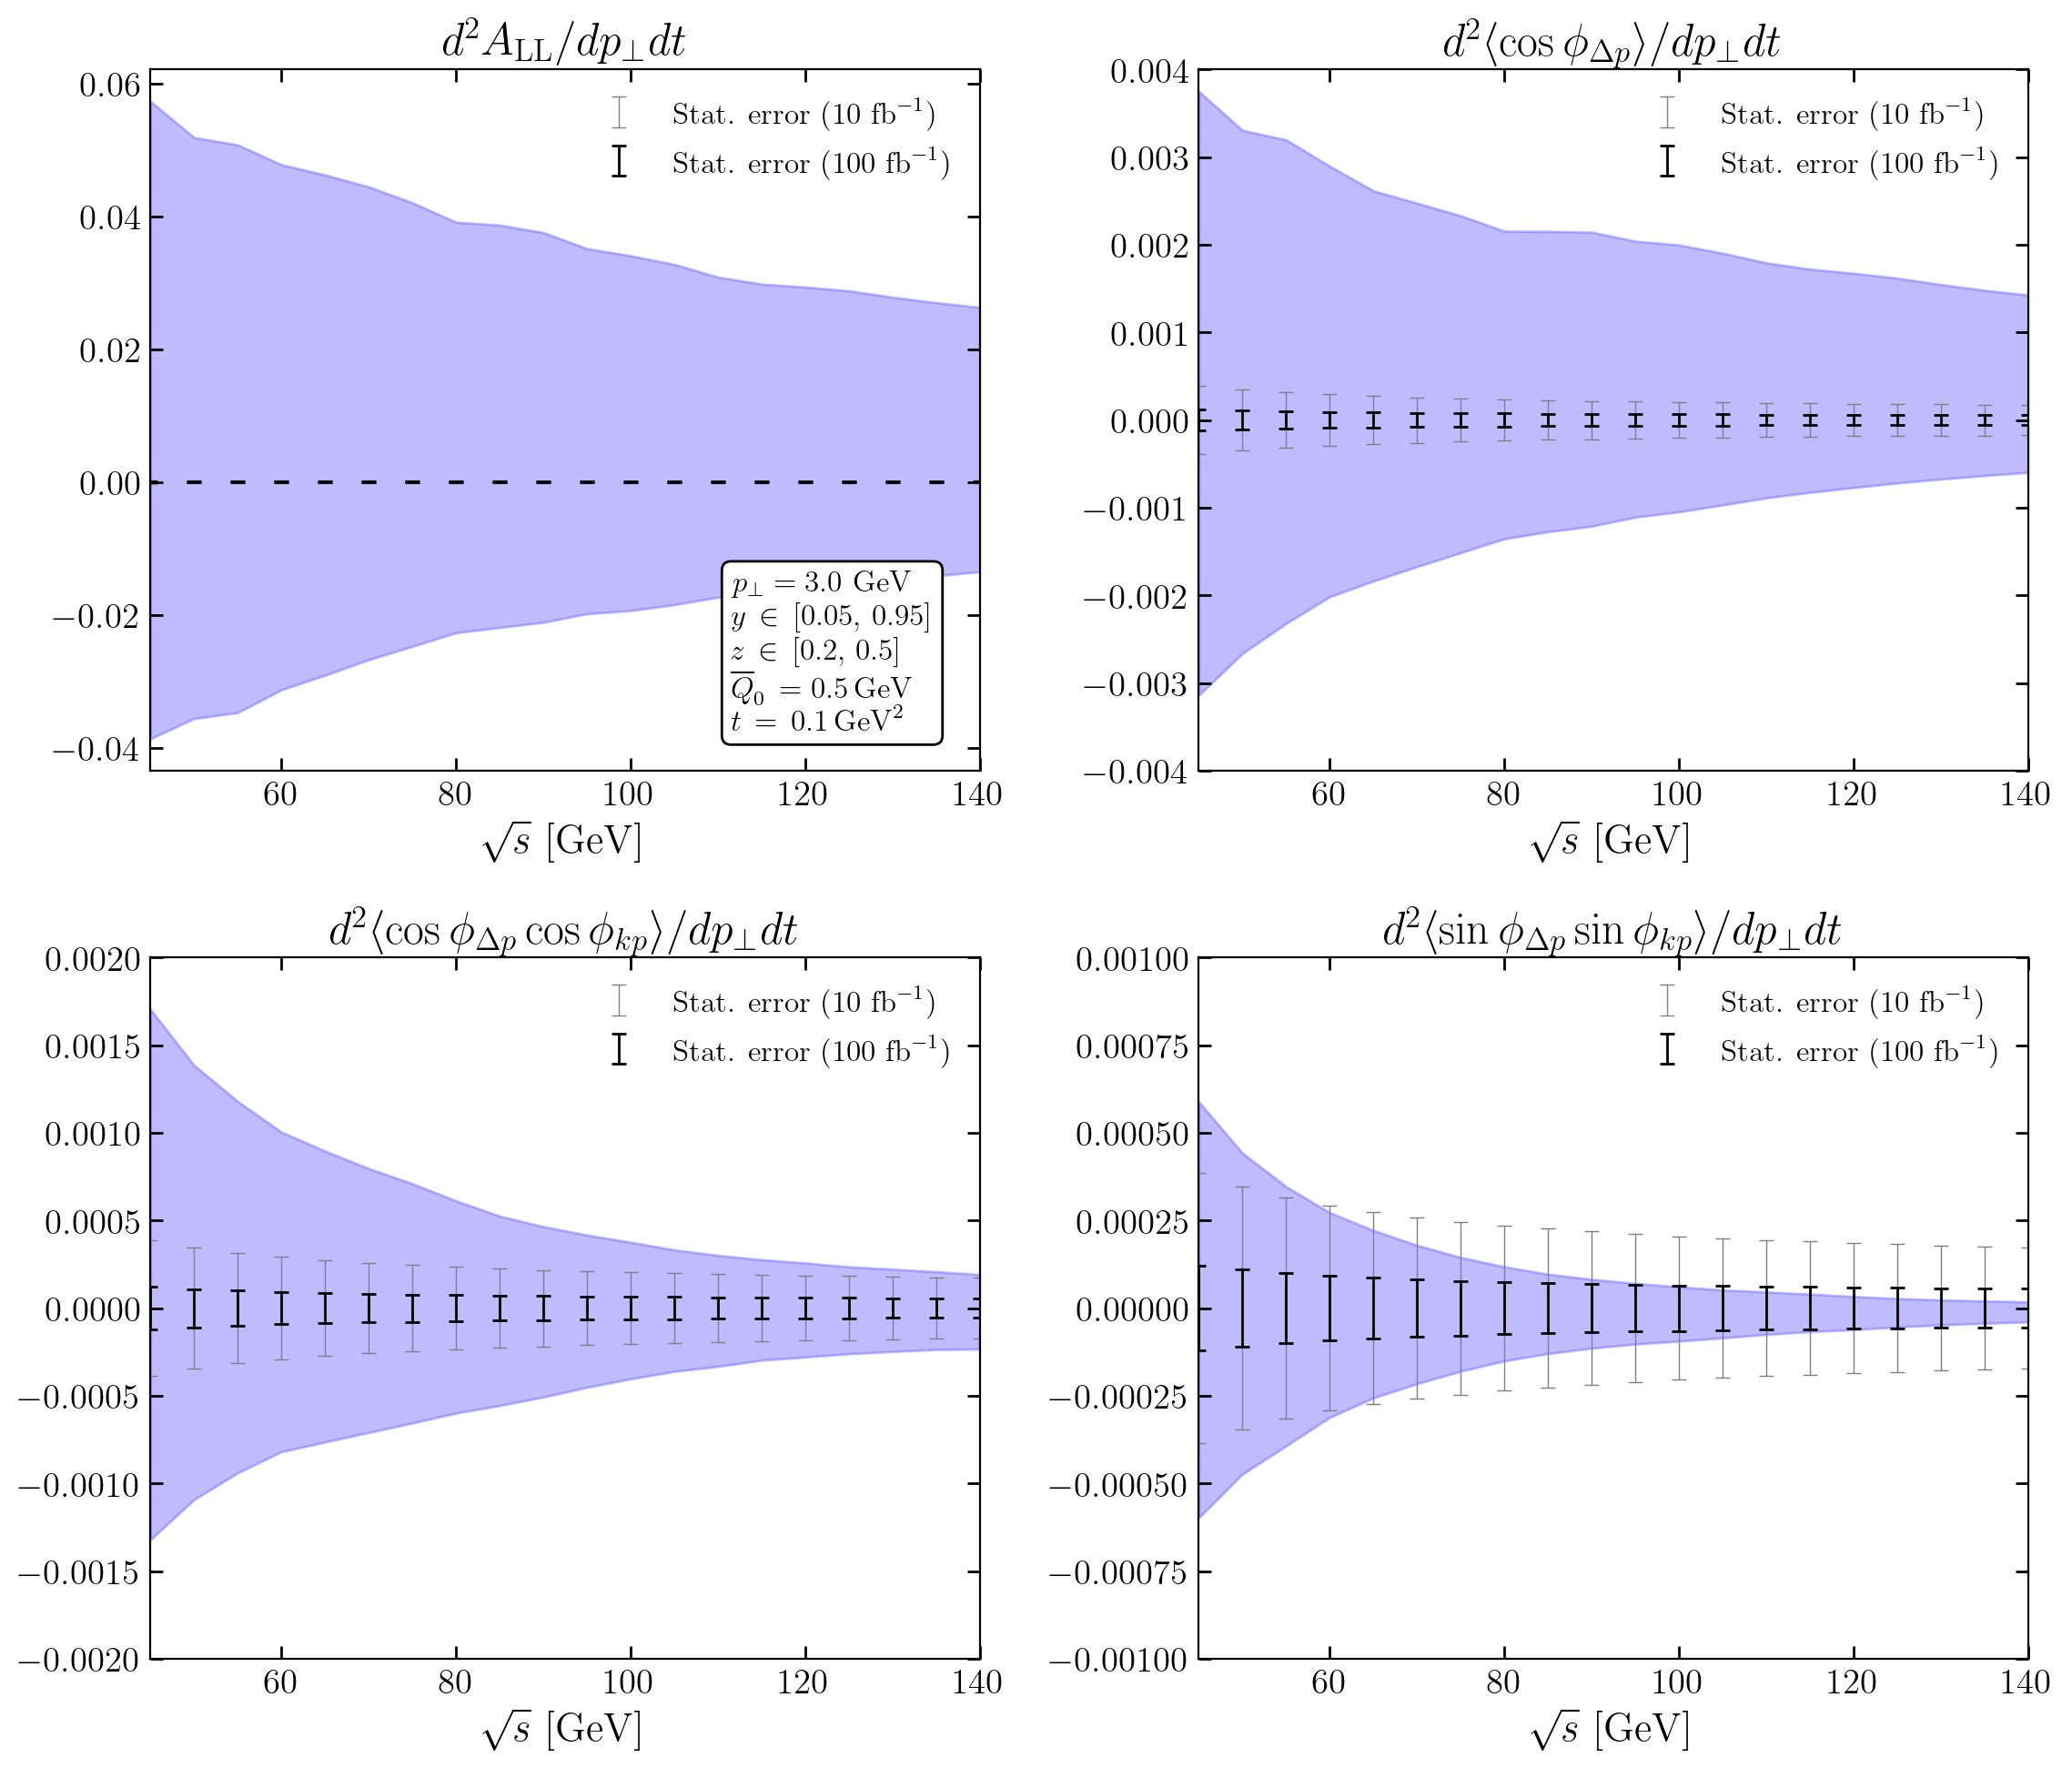

In [26]:
# plot azimuthal correlations
asp_ratio = 3.5/3
psize = 5

nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))
axs = [ax[irow, icol] for irow in range(nrows) for icol in range(ncols)]

save_plots = False
plot_bands = True
plot_error = True

color = '#6257ff'

for icorr, corr in enumerate(corrs):
    errors = [all_error, tt_error, tt_error, tt_error]

    if plot_bands:
        axs[icorr].fill_between(roots_values, bands['lower'][corr], bands['upper'][corr], color=color, alpha=0.4)
    
    else:
        for irep, rep in enumerate(data['reps']):
            axs[icorr].plot(roots_values, np.array(rep[corr]), alpha=0.2, color=color)

    if plot_error: 
        axs[icorr].errorbar(
                roots_values, np.zeros(all_error.shape), yerr=np.sqrt(10)*errors[icorr], fmt='o',
                capsize=3, elinewidth=0.5, capthick=0.5, color='gray', markersize=0, 
                label=rf'Stat. error ({round(lumi/10)} $\mathrm{{fb}}^{{-1}}$)'
        )
        axs[icorr].errorbar(
                roots_values, np.zeros(all_error.shape), yerr=errors[icorr], fmt='o',
                capsize=3, elinewidth=1, capthick=1, color='black', markersize=0, 
                label=rf'Stat. error ({lumi} $\mathrm{{fb}}^{{-1}}$)'
        )


# axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[0].set_title(fr'$ d^2 A_{{\mathrm{{LL}}}} / dp_\perp dt  $')
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[0].legend(frameon=False)
axs[0].text(
    0.7, 0.05, info_text, 
    transform=axs[0].transAxes,
    ha='left', va='bottom', 
    fontsize=12, wrap=True, 
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
)
# axs[0].semilogy()
# axs[0].set_ylim([-700, 700])

# axs[1].axhline(y=0, color='lightgray', linestyle='-')
axs[1].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[1].set_title(fr'$ d^2 \langle \cos \phi_{{\Delta p}} \rangle  / dp_\perp dt  $')
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[1].legend(frameon=False)
axs[1].set_ylim([-0.004, 0.004])
# axs[1].semilogy()


# axs[2].axhline(y=0, color='gray', linestyle='-')
axs[2].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[2].set_title(fr'$ d^2 \langle \cos\phi_{{\Delta p}} \cos\phi_{{k p}} \rangle / dp_\perp dt $')
axs[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[2].legend(frameon=False)
axs[2].set_ylim([-0.002, 0.002])
# axs[2].semilogy()

# axs[3].axhline(y=0, color='gray', linestyle='-')
axs[3].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[3].set_title(fr'$ d^2\langle \sin\phi_{{\Delta p}} \sin \phi_{{k p}}  \rangle / dp_\perp dt $')
axs[3].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[3].legend(frameon=False)
axs[3].set_ylim([-0.001, 0.001])
# axs[3].semilogy()
# axs[1].legend()

plt.tight_layout()
plt.show()

if save_plots:
    if plot_bands:
        fig.savefig('plots/dsa_energy_band.pdf', dpi=400, bbox_inches="tight")
    else:
        fig.savefig('plots/dsa_energy_lines.pdf', dpi=400, bbox_inches="tight")
